In [1]:
import os
import json
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from itertools import zip_longest
from IPython.display import HTML, Markdown, display

Helper functions from **<u>util.py</u>**

In [2]:
from util_2 import (
    ticker_option, combine_dfs, get_stock_price, 
    prepare_ml_dataset, concatenate_strings, train_model,
    train_model_regularization,
    view_shap_value_for_instance
)

In [3]:
warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:.3f}'.format

# Machine Learning 2 - Final Project

<center><img src="images/title.png" width='100%'/>

## Abstract

This project aims to use ML models as an alternative to pricing options aside from the more popular and traditionally used Black-Scholes-Merton equation. Finance data was obtained from Yahoo! Finance via webscraping and Linear and Tree Models were used as prospective models for Machine Learning. 

Even though the best performing models exhibit overfitting the models performance in terms of $R^2$, MAE, MSE, and MAPE metrics mostly outperformed the Black-Scholes-Merton baseline. To handle overfitting future work is suggested to simplify the models and introduce regularizations. This project aims possible usecase in pricing options effectively and leveraging this in capturing immense profits in the Global Derivatives Market valuing around 1 quadrillion dollars.

## Introduction

### What are options?

<center><img src="images/option_def.png" width='50%'/>

<p>Option are derivative contracts that give the holder the right but not the obligation to buy or sell an underlying asset or security. This is at a predetermined price before the contract expiry. Buying (call) and selling (put) has a price which is called the option's premium. Traditional models such as Black-Scholes and Binomial models can be used to price the options.<sup>1</sup> Black-Scholes is one of the most widely used models tha uses the following input variables - strike price, current price, time to expiration, risk-free rate, and volatility. It is a mathematical equation that estimates the theoretical value of derivatives based on other investment instruments, taking into account the impact of time and other risk factors. Although it is a stable framework, the model relies on several assumptions that may materialize into the actual price of the security.<sup>2</sup> </p>

<center><img src="images/advantages.png" width='70%'/>

### What are the advantages of options?

- One of the advantages of using options is that it limits your downside. If the price of the options falls dramatically, your loss is confined to the initial premium paid for the option. 
- Another advantage is that it provides leverage. Options allows you to control a larger amount of the underlying asset with a relatively low investment, which is the option price.<sup>4</sup></p>
- Options can also be used in dynamic hedging where you can offset losses from an option by owning some stock. Both the option and the underlying stock can reduce the risk in your portfolio due to price movements<sup>3</sup>. 

<p>The use of options in investment strategies can offer a range of advantages to investors. Machine learning can bring a more adaptive and precise method for valuing options, in contrast to traditional models. By integrating machine learning into the process of options pricing, it becomes possible to harness a more sophisticated and nuanced tool. This, in turn, can contribute significantly to improved decision-making and the development of more effective investment strategies.</p>

### Popular Method for Options Pricing (Black-Scholes-Merton Equation)

$$\frac{\partial V}{\partial t} + \frac{1}{2} \sigma^2 S^2 \frac{\partial^2 V}{\partial S^2} + rS \frac{\partial V}{\partial S} - rV = 0
$$

Where:\
$V = \text{option price}$\
$S = \text{strike price}$\
$t = \text{expiry}$\
$r = \text{risk-free rate}$\
$\sigma = \text{volatility}$

**Equation 1**. Black-Scholes-Merton differential Equation

Given the inputs and some assumptions, Black-Scholes-Merton equation can determine the fair price of an option. Underlying concept that governs it is the Statistical Random Walk, similar to how heat propagates from regions of high to low temperature and a drift component depending on how the underlying financial asset is performing currently. Caveats of using this traditional model is that some Greek letter inputs are hard to obtain like the risk-free rate and volatility and certain assumptions like the equation is based on EU options where in options are only exercised at expiry, assumes no dividends and prices of the option follows a normal distribution.

## Problem Statement

Traditional option pricing models, such as Black-Scholes, have limitations in capturing the complexities of real-world markets. There is a need for more adaptive and accurate methods that can leverage the vast amounts of available market data. Machine learning offers a promising solution by uncovering hidden patterns that traditional models miss, but its application in option pricing is still underexplored and lacks comprehensive validation.

In [4]:
use_cache = True

In [5]:
if os.path.exists('price.json') & use_cache:
    # Read the dictionary from the JSON file
    with open('price.json', 'r') as json_file:
        price_dict = json.load(json_file)
else:
    price_dict = {}

In [6]:
# for mean shap value
fig1, axes1 = plt.subplots(2, 3, figsize=(30, 10), gridspec_kw={'hspace': 0.65, 'wspace': 0.65})
axes_flat1 = axes1.flatten()
plt.close(fig1)

In [7]:
# for shap waterfall plot
fig2, axes2 = plt.subplots(3, 2, figsize=(30, 10), gridspec_kw={'hspace': 1, 'wspace': 1})
axes_flat2 = axes2.flatten()
plt.close(fig2)

In [8]:
ticker_list = [
    # "MSFT"
    "MSFT", "AAPL", "NVDA", "AMZN", "META", 
    "GOOGL", "GOOG", "BRK.B", "LLY", "AVGO", "JPM", 
    "XOM", "TSLA", "UNH", "V", "PG", "MA", "COST", "JNJ", "HD", "MRK",
]

## Dataset Data Dictionary

| Type       | Variable          | Definition                                                                                                                                              |
|------------|-------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------|
| Categorical| Contract Symbol   | Contains the Root symbol (ticker symbol) + Expiration Year (yy) + Expiration Month (mm) + Expiration Day (dd) + Call/Put Indicator (C or P) + Strike Price |
| Datetime   | Last Trade Date   | Last trade date of the option                                                                                                                          |
| Numerical  | Strike            | The option's strike price is the price at which the security can be bought (call) or sold (put)                                                       |
| Numerical  | Last Price        | The last price at which the option was traded                                                                                                           |
| Numerical  | Bid               | The price at which the buyers are willing to trade                                                                                                      |
| Numerical  | Ask               | The price at which the sellers are willing to trade                                                                                                     |
| Numerical  | Change            | The amount of change in the price of the option                                                                                                         |
| Numerical  | Volume            | The number of options bought and sold                                                                                                                   |
| Numerical  | Open Interest     | The number of options or futures contracts held by traders in active positions                                                                          |
| Numerical  | Implied Volatility| The likelihood of future changes in a given security's price                                                                                             |
| Categorical| In the Money      | An option that presents a profit opportunity due to the relationship between the strike price and the prevailing market price of the underlying asset  |
| Categorical| Contract Size     | The quantity of the underlying value that corresponds to one option contract                                                                            |
| Categorical| Currency          | The currency in which the option is denominated                                                                                                         |
| Categorical| Type              | Call/Put                                                                                                                                                 |
| Datetime   | Expiry            | The last day in which the option can trade or be exercised, before it will expire and cease to exist                                                  |
| Numerical  | Days to Expire    | The remaining time left until an options contract or futures contract expires                                                                            |
| Numerical  | Stock Price       | The current market price of the underlying asset                                                                                                        |
| Numerical  | Risk Free Rate       | Risk free rate calculated from ^TNX (CBOE Interest Rate 10 Year T No) at the time of trade                                                                                                   |
| Categorical| Option Ticker     | A unique identifier assigned that corresponds to the underlying assets for the options                                                                  |

**Table 1**. Dataset Dictionary

In [9]:
df = combine_dfs(ticker_list, price_dict)
display(df.head(5))
display(Markdown("**Table 2**. Pre-proccessed Dataset"))

No options found for BRK.B


,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency,type,exp,days_to_exp,stockPrice,risk_free_rate,option_ticker
0,AMZN240621P01540000,2022-04-27,1540.000,138.000,114.500,130.500,0.000,0.000,1.000,1.000,0.000,True,REGULAR,USD,put,2024-06-21,785.210,138.170,2.820,AMZN
1,AMZN240621P01660000,2022-04-28,1660.000,84.300,145.000,161.000,0.000,0.000,3.000,2.000,0.000,True,REGULAR,USD,put,2024-06-21,784.290,144.600,2.860,AMZN
2,AMZN240621C01840000,2022-04-28,1840.000,1223.650,774.000,793.000,0.000,0.000,2.000,2.000,0.000,False,REGULAR,USD,call,2024-06-21,784.430,144.600,2.860,AMZN
3,AMZN240621C01640000,2022-04-29,1640.000,1114.450,904.000,922.000,0.000,0.000,2.000,2.000,0.000,False,REGULAR,USD,call,2024-06-21,783.390,124.280,2.890,AMZN
4,AMZN240621C01740000,2022-04-29,1740.000,998.000,838.000,856.000,0.000,0.000,1.000,1.000,0.000,False,REGULAR,USD,call,2024-06-21,783.180,124.280,2.890,AMZN


**Table 2**. Pre-proccessed Dataset

In [10]:
# save to json 
with open('price.json', 'w') as json_file:
    json.dump(price_dict, json_file, indent=4)

## Exploratory Data Analysis

### Dataset overview

For the data overview, we display the first few rows of the dataset to get an initial sense of the data and obtained the 
data types each column and identify potential issues. All columns are numerical and non-null in nature. 

In [11]:
df_prep =  prepare_ml_dataset(df)
display(df_prep.head(5))
display(Markdown("**Table 3**. Post-proccessed Dataset"))
display(df_prep.info())

,strike,change,volume,openInterest,impliedVolatility,days_to_exp,stockPrice,risk_free_rate,type_call,lastPrice
0,1540.000,0.000,1.000,1.000,0.000,785.210,138.170,2.820,0,138.000
1,1660.000,0.000,3.000,2.000,0.000,784.290,144.600,2.860,0,84.300
2,1840.000,0.000,2.000,2.000,0.000,784.430,144.600,2.860,1,1223.650
3,1640.000,0.000,2.000,2.000,0.000,783.390,124.280,2.890,1,1114.450
4,1740.000,0.000,1.000,1.000,0.000,783.180,124.280,2.890,1,998.000


**Table 3**. Post-proccessed Dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22609 entries, 0 to 22608
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   strike             22609 non-null  float64
 1   change             22609 non-null  float64
 2   volume             22609 non-null  float64
 3   openInterest       22609 non-null  float64
 4   impliedVolatility  22609 non-null  float64
 5   days_to_exp        22609 non-null  float64
 6   stockPrice         22609 non-null  float64
 7   risk_free_rate     22609 non-null  float64
 8   type_call          22609 non-null  int32  
 9   lastPrice          22609 non-null  float64
dtypes: float64(9), int32(1)
memory usage: 1.6 MB


None

### Summary statistics
Shown below are the summary statistics of the numerical columns with no missing values. 

In [12]:
display(df_prep.describe())
display(Markdown("**Table 4**. Dataset summary statistics"))

,strike,change,volume,openInterest,impliedVolatility,days_to_exp,stockPrice,risk_free_rate,type_call,lastPrice
count,22609.000,22609.000,22609.000,22609.000,22609.000,22609.000,22609.000,22609.000,22609.000,22609.000
mean,641.737,-4.427,37.874,99.581,0.302,314.110,679.635,4.367,0.650,167.544
std,529.717,75.358,320.131,557.130,1.679,268.555,443.359,0.234,0.477,208.659
min,1.670,-1156.950,1.000,0.000,0.000,6.170,94.650,2.610,0.000,10.020
25%,215.000,0.000,1.000,0.000,0.000,71.320,196.890,4.290,0.000,33.160
50%,480.000,0.000,3.000,0.000,0.000,225.230,495.060,4.430,1.000,81.000
75%,920.000,0.000,10.000,14.000,0.016,560.290,1205.650,4.430,1.000,211.050
max,4700.000,852.570,19514.000,32298.000,48.195,1059.290,1436.170,4.990,1.000,2335.300


**Table 4**. Dataset summary statistics

In [13]:
display(df_prep.isnull().sum())

strike               0
change               0
volume               0
openInterest         0
impliedVolatility    0
days_to_exp          0
stockPrice           0
risk_free_rate       0
type_call            0
lastPrice            0
dtype: int64

### Data Visualization
The histograms revealed the visual distribution of the variables. `strike`, `impliedVolatility`, `lastPrice`, and at certain extend, `volume` and `openInterest`, were right-skewed distribution while `type_call`, and `type_put` are all binary. The variable `days_to_exp` and `stockPrice` didn't follow a normal nor skewed distribution. 

In [14]:
fig, axes = plt.subplots(4, 3, figsize=(20, 20), gridspec_kw={'hspace': 0.35})
axes_flat = axes.flatten()
plt.close(fig)
for ax, col in zip_longest(axes_flat, df_prep.iloc[:, :].columns):
    if col != None:
        ax.hist(df_prep[col], bins=20, color='skyblue', edgecolor='black')
        ax.set_title(f"{col}")
        ax.set_xlabel('Range of Values')
        ax.set_ylabel('Count')
    else:
        ax.axis("off")

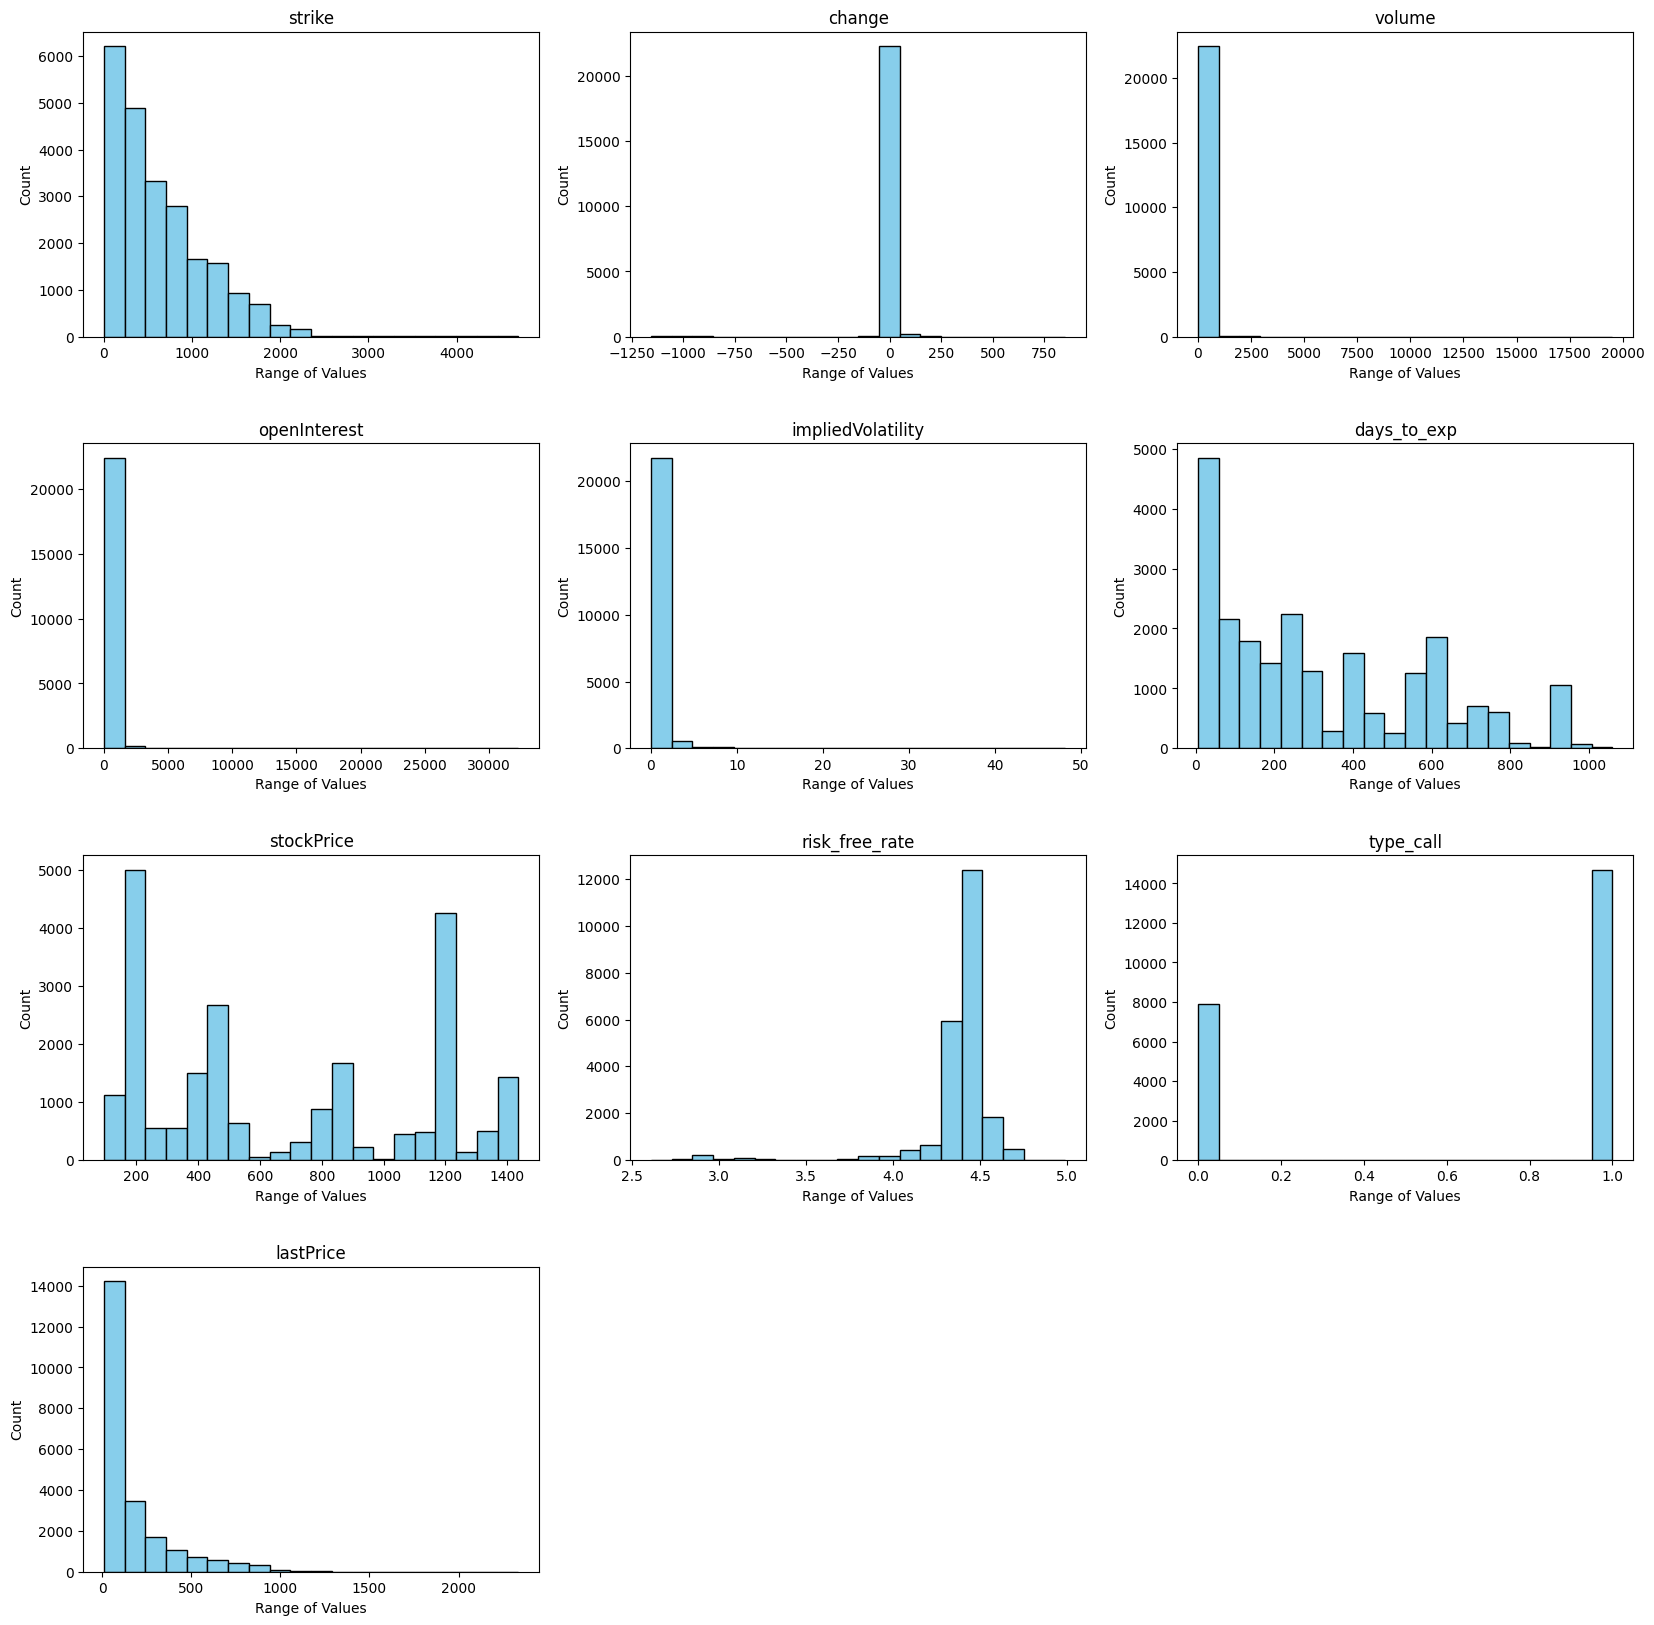

**Figure 1**. Dataset histogram

In [15]:
display(fig)
display(Markdown("**Figure 1**. Dataset histogram"))

### Outliers
The Box Plots that were generated might identify outliers that may helps us understand the spread of the data. Though there were presence of outliers, we didn't remove them form the dataset.

In [16]:
fig, axes = plt.subplots(4, 3, figsize=(18, 24))
plt.close(fig)
columns = [
    'strike', 'change', 'volume', 'openInterest',
    'impliedVolatility', 'days_to_exp', 'stockPrice',
    'type_call', 'type_put', 'lastPrice'
]
columns = [
    'strike', 'change', 'volume', 'openInterest',
    'impliedVolatility', 'days_to_exp', 'stockPrice',
    'type_call', 'lastPrice'
]

# Plot each box plot in the respective subplot
for ax, column in zip_longest(axes.flatten(), columns):
    if column != None:
        sns.boxplot(x=df_prep[column], ax=ax)
        ax.set_title(f'Box Plot of {column}')
    else:
        ax.axis("off")

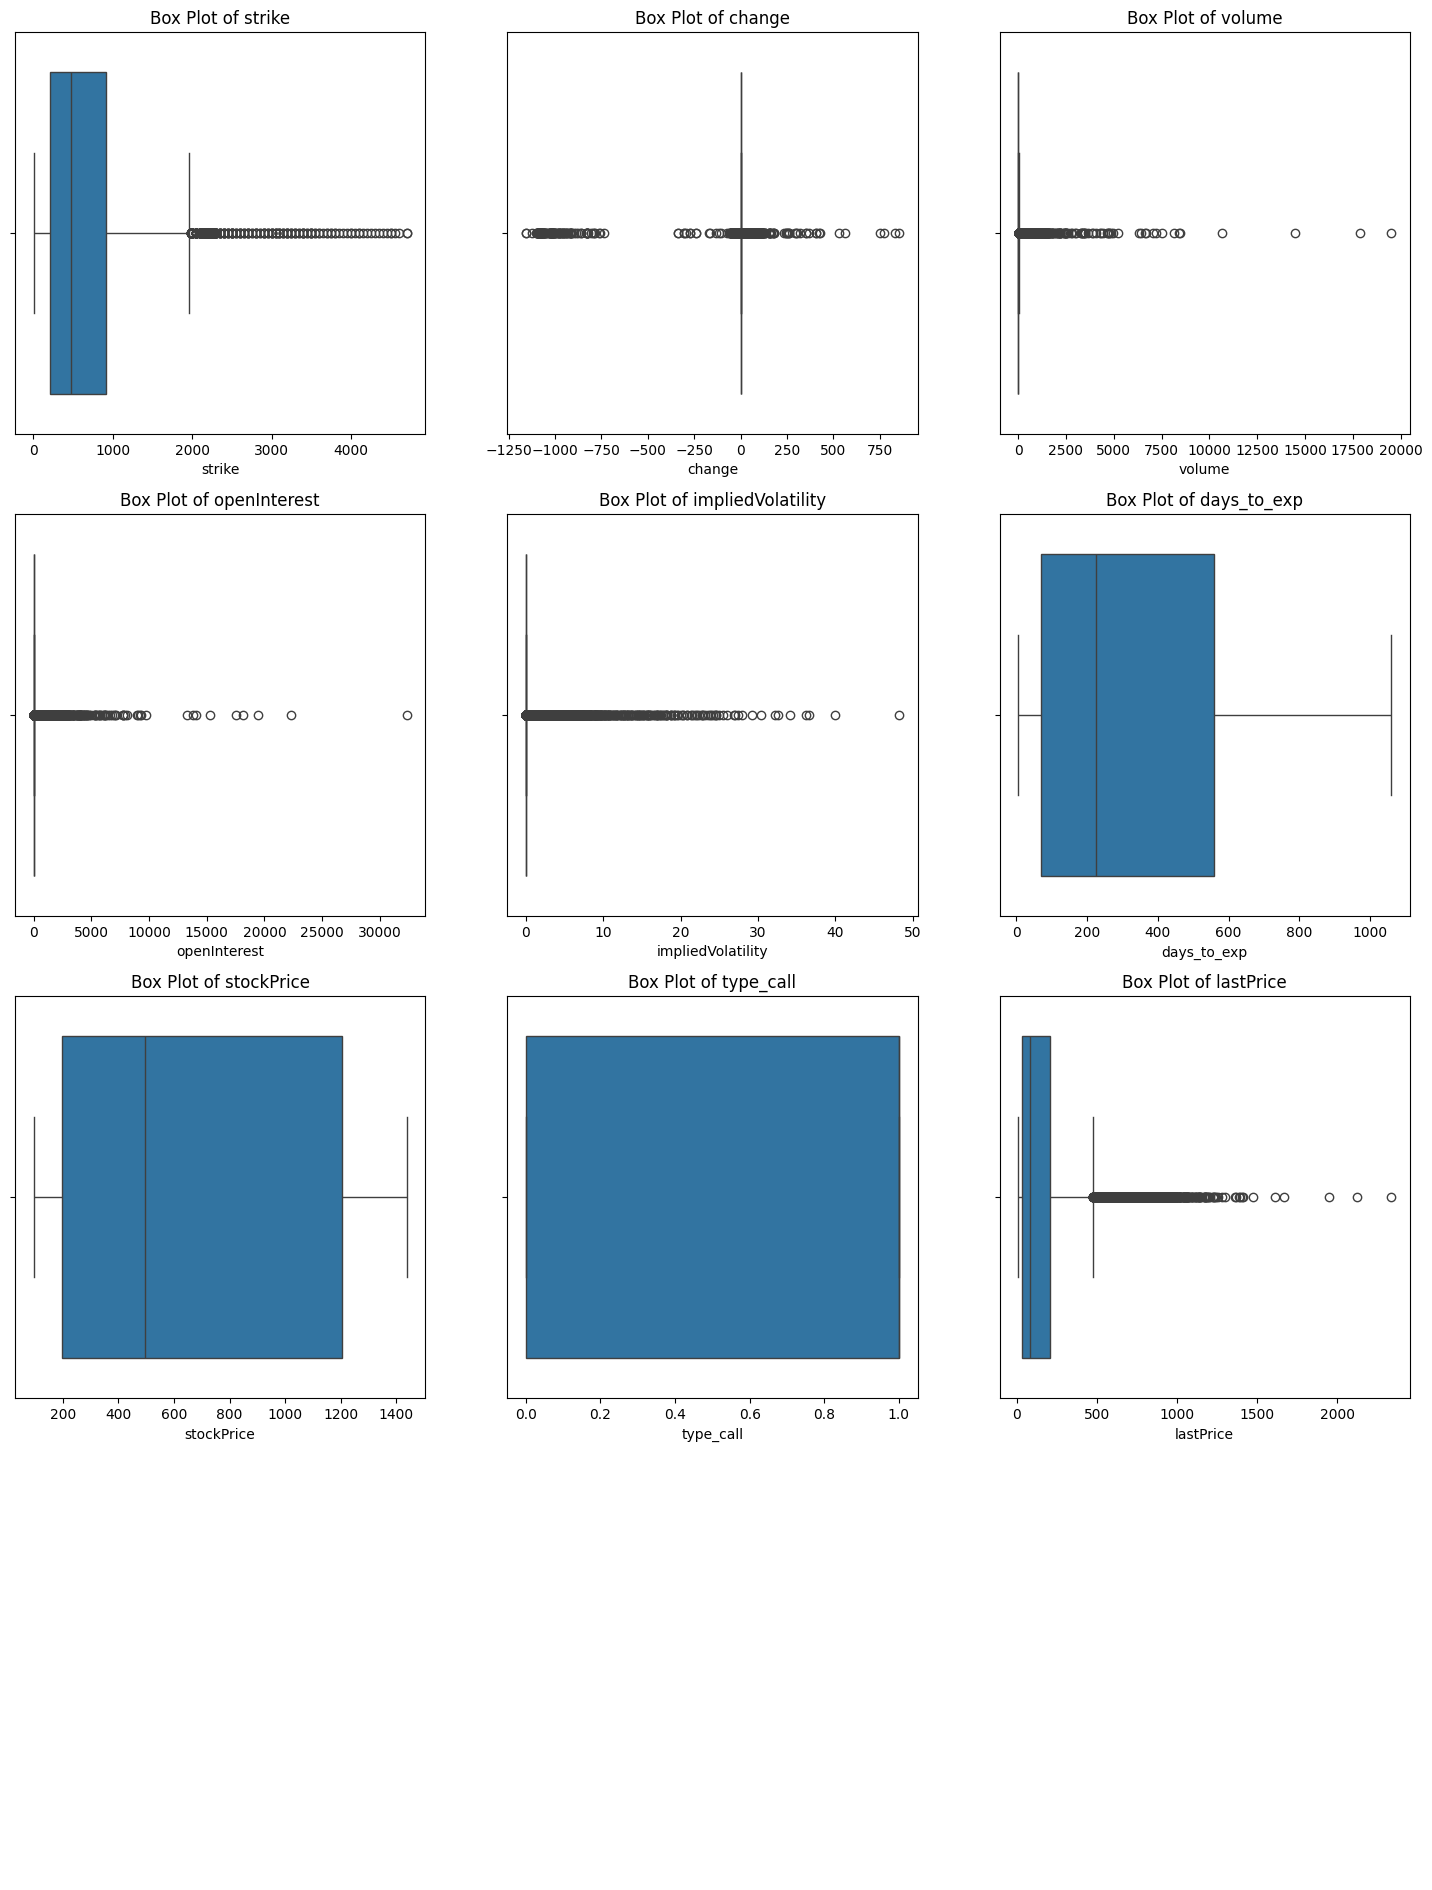

**Figure 2**. Dataset boxplots

In [17]:
display(fig)
display(Markdown("**Figure 2**. Dataset boxplots"))

### Correlation Analysis
The Correlation Matrix displayed computed pairwise correlation of columns and visualize it with a heatmap to identify highly correlated variables. Based on the matrix, there is moderate positive relationship between `strike` and `stockprice`.

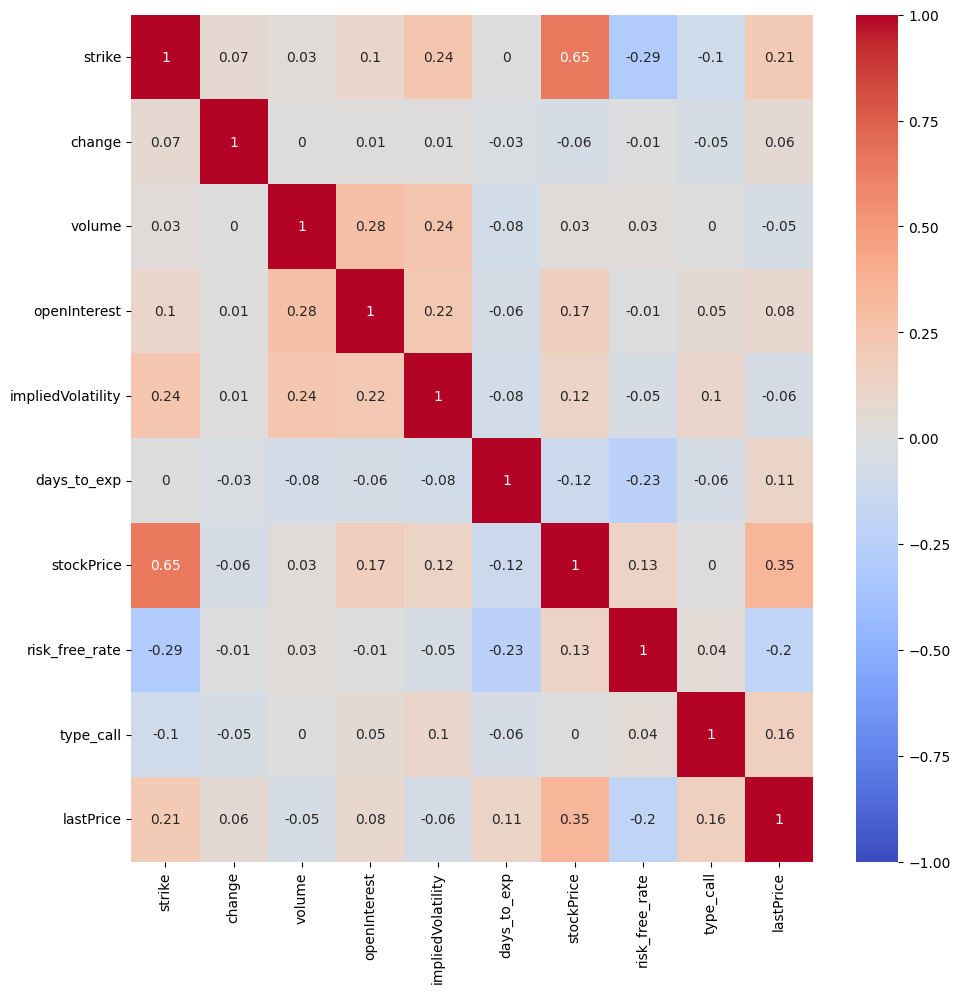

**Figure 3**. Dataset correlation heatmap

In [18]:
plt.figure(figsize = (11, 11))
sns.heatmap(round(pd.DataFrame(df_prep, columns=df_prep.columns).corr(), 2), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.show()
display(Markdown("**Figure 3**. Dataset correlation heatmap"))

## Methodology

Utilizing data from Yahoo finance, our team will apply Linear, Decision Tree, Random Forest, Gradient Boosting Method and Model Explainability using SHAP to help explain factors that influence options pricing.

<center><img src="images/methodology.png" width='70%'/>

<span style='margin-right: 100px; line-height: 1.5'>

<b> Data Collection </b>

- The dataset was obtained by web scraping the data from Yahoo! Finance. The top 20 tickers were used based on the volume of transactions as part of the study. The ranking is based on the weight of the market capitalization as compared to the overall market<sup>3</sup>.

<b> Data Cleaning and Pre-Processing  </b>
- The team performed data cleaning and preprocessing steps such as data type conversions, removing of rows will null values, and filtering of transactions that are less than ten transactions.
    
<b> Feature Engineering and Feature Selection</b>

- One-hot encoding was performed for categorical data. For feature selection team only retained relevant columns

<b> Exploratory Data Analysis </b>

- The team looked at distributions to understand any asymmetry or possible outliers per feature. Correlation analysis was used to aid in feature selection and understanding of feature relationships.

<b> Model Selection and Hyperparameter Tuning </b> <br>

- The models that the team explored are Linear, Decision Tree, Random Forest and Gradient Boosting Method. Singular model was implemented to capture generalization and serve as baseline whereas per ticker model to address bias and scale per ticker

<b> Analysis and Interpretation of Results </b> <br>

- Teams looks at the $R^2$, MAE, MSE, and MAPE of the best performing ML models vs. Black-Scholes-Merton as a baseline
 
</span>

In [19]:
other_outs_ = []

Singular Model

In [20]:
X_test, y_test, shap_values, X, shap_explainer, bm, other_outs = train_model(df_prep, axes_flat1[0], "Singular Model")
other_outs_.append(other_outs)
view_shap_value_for_instance(X_test, y_test, shap_values, X, shap_explainer, bm, 0, axes_flat2[0], "Singular Model")

 99%|===================| 5597/5653 [00:43<00:00]        

Per ticker model

In [21]:
for ticker, ax_shap_sum, ax_shap_sum2 in zip_longest(ticker_list[0:5], axes_flat1[1:], axes_flat2[1:]):
    if ticker == None:
        ax_shap_sum.axis('off')
        continue
    # print(ticker)
    
    df_ = df[df['option_ticker'] == ticker].reset_index(drop=True)
    df_prep_ =  prepare_ml_dataset(df_)

    X_test, y_test, shap_values, X, shap_explainer, bm, other_outs = train_model(df_prep_, ax_shap_sum, ticker)
    other_outs_.append(other_outs)
    view_shap_value_for_instance(X_test, y_test, shap_values, X, shap_explainer, bm, 0, ax_shap_sum2, ticker)

## Results and Discussion

In this section we will be commenting on the quality and performance of the model and some visualization on which features are the most impotant and their contribution to the option price via SHAP.

In [22]:
df_best_models = pd.concat([t[0] for t in other_outs_])
df_best_models['ticker'] = ['Singular Model'] + ticker_list[0:5]
notable_colums = [
    ('model', ''),
    ('r2', 'test'),
    ('mae', 'test'),
    ('mse', 'test'),
    ('mape', 'test'),
    ('ticker', '')
]
df_best_ = df_best_models[notable_colums]
df_best_.columns = [t[0] for t in notable_colums]

df_bsm = pd.concat([t[1] for t in other_outs_])
df_bsm['ticker'] = ['Singular Model'] + ticker_list[0:5]
display(df_best_models)
display(Markdown("**Table 5**. Train-Test Model performance metrics"))

model    r2          mae             mse  \
                                   train  test  train   test    train   
0  GradientBoostingRegressor_4_250 0.975 0.956 21.802 25.465 1090.435   
0  GradientBoostingRegressor_4_250 1.000 0.991  1.225  3.963    2.572   
0  GradientBoostingRegressor_4_250 1.000 0.990  0.438  2.314    0.338   
0  GradientBoostingRegressor_4_250 0.997 0.986 10.772 17.202  230.636   
0  GradientBoostingRegressor_4_250 1.000 0.876  1.380 22.938    4.305   
0  GradientBoostingRegressor_4_250 0.999 0.979  2.846  7.738   13.516   

            mape                ticker  
      test train  test                  
0 1890.902 0.370 0.409  Singular Model  
0   44.766 0.027 0.077            MSFT  
0   17.510 0.013 0.060            AAPL  
0 1121.500 0.108 0.185            NVDA  
0 6913.283 0.034 0.170            AMZN  
0  299.154 0.051 0.122            META

**Table 5**. Train-Test Model performance metrics

### Overfitting

Looks like the best ML models had displayed signs of overfitting as a rule of thumb if the test-train scores shows 10% difference between each other the ML model might be overfitting. Suggestions to improve this model is to simplify the model, get more data for training or applying regularization.

In [23]:
df_diff = df_best_models.loc[:, df_best_models.columns.get_level_values(1).str.contains('test|train|')]
df_diff.columns = [f"{t[0]}_{t[1]}".strip("_") for t in list(df_diff.columns.to_flat_index())]

for i in ['r2', 'mae', 'mse', 'mape']:
    df_diff[f"{i}_change (%)"] =  (100*((df_diff[f"{i}_test"] - df_diff[f"{i}_train"])/df_diff[f"{i}_train"])).abs()

display(df_diff.loc[:, df_diff.columns.str.contains('change|ticker|model')])
display(Markdown("**Table 6**. Train-Test Model performance metrics % difference"))

,model,ticker,r2_change (%),mae_change (%),mse_change (%),mape_change (%)
0,GradientBoostingRegressor_4_250,Singular Model,1.944,16.804,73.408,10.372
0,GradientBoostingRegressor_4_250,MSFT,0.811,223.377,1640.241,179.163
0,GradientBoostingRegressor_4_250,AAPL,0.936,428.195,5087.410,374.867
0,GradientBoostingRegressor_4_250,NVDA,1.139,59.686,386.263,71.298
0,GradientBoostingRegressor_4_250,AMZN,12.435,1561.778,160490.790,408.426
0,GradientBoostingRegressor_4_250,META,1.997,171.848,2113.307,138.381


**Table 6**. Train-Test Model performance metrics % difference

Add regularization to best performing model by setting capping the number of estimators to 100,  max features to square root, restricting the number of leaf nodes, and increasing the minimum number of samples required to split a node or to be at a leaf node. Applying regularization appears to improve MAE, MSE and MAPE scores. 

In [24]:
other_outs_reg = []

X_test_reg, y_test_reg, shap_values_reg, X_reg, shap_explainer_reg, bm_reg, other_outsreg = train_model_regularization(df_prep, None, "Singular Model")
other_outs_reg.append(other_outsreg)
view_shap_value_for_instance(X_test_reg, y_test_reg, shap_values_reg, X_reg, shap_explainer_reg, bm_reg, 0, None, "Singular Model")

100%|===================| 5636/5653 [00:19<00:00]        

In [25]:
for ticker, ax_shap_sum, ax_shap_sum2 in zip_longest(ticker_list[0:5], axes_flat1[1:], axes_flat2[1:]):
    if ticker == None:
        # ax_shap_sum.axis('off')
        continue
    # print(ticker)
    
    df_ = df[df['option_ticker'] == ticker].reset_index(drop=True)
    df_prep_ =  prepare_ml_dataset(df_)

    X_test_reg, y_test_reg, shap_values_reg, X_reg, shap_explainer_reg, bm_reg, other_outsreg = train_model_regularization(df_prep_, None, ticker)
    other_outs_reg.append(other_outsreg)
    view_shap_value_for_instance(X_test_reg, y_test_reg, shap_values_reg, X_reg, shap_explainer_reg, bm_reg, 0, None, ticker)

In [26]:
df_best_models_reg = pd.concat([t[0] for t in other_outs_reg])
df_best_models_reg['ticker'] = ['Singular Model'] + ticker_list[0:5]
notable_colums = [
    ('model', ''),
    ('r2', 'test'),
    ('mae', 'test'),
    ('mse', 'test'),
    ('mape', 'test'),
    ('ticker', '')
]
df_best_reg = df_best_models_reg[notable_colums]
df_best_reg.columns = [t[0] for t in notable_colums]

df_bsm_reg = pd.concat([t[1] for t in other_outs_reg])
df_bsm_reg['ticker'] = ['Singular Model'] + ticker_list[0:5]
display(df_best_models_reg)
display(Markdown("**Table 7**. Train-Test Model performance metrics"))

model    r2          mae  \
                                                     train  test  train   
0  GradientBoostingRegressor(max_features='sqrt'_... 0.909 0.886 39.937   
0  GradientBoostingRegressor(max_features='sqrt'_... 0.994 0.978  4.318   
0  GradientBoostingRegressor(max_features='sqrt'_... 0.995 0.972  2.299   
0  GradientBoostingRegressor(max_features='sqrt'_... 0.974 0.959 31.276   
0  GradientBoostingRegressor(max_features='sqrt'_... 0.977 0.816 17.913   
0  GradientBoostingRegressor(max_features='sqrt'_... 0.988 0.956  9.204   

              mse            mape                ticker  
    test    train      test train  test                  
0 42.533 3886.447  4842.586 0.611 0.634  Singular Model  
0  7.261   32.128   115.697 0.098 0.154            MSFT  
0  4.512    9.236    49.805 0.069 0.120            AAPL  
0 37.525 2045.250  3199.637 0.351 0.404            NVDA  
0 37.049 1369.552 10440.091 0.304 0.418            AMZN  
0 14.463  167.351   634.107 0.161 0.238            META

**Table 7**. Train-Test Model performance metrics

In [27]:
df_diff_reg = df_best_models_reg.loc[:, df_best_models_reg.columns.get_level_values(1).str.contains('test|train|')]
df_diff_reg.columns = [f"{t[0]}_{t[1]}".strip("_") for t in list(df_diff_reg.columns.to_flat_index())]

for i in ['r2', 'mae', 'mse', 'mape']:
    df_diff_reg[f"{i}_change (%)"] =  (100*((df_diff_reg[f"{i}_test"] - df_diff_reg[f"{i}_train"])/df_diff_reg[f"{i}_train"])).abs()

display(df_diff_reg.loc[:, df_diff_reg.columns.str.contains('change|ticker|model')])
display(Markdown("**Table 8**. Train-Test Model performance metrics % difference regularized"))

,model,ticker,r2_change (%),mae_change (%),mse_change (%),mape_change (%)
0,GradientBoostingRegressor(max_features='sqrt'_...,Singular Model,2.534,6.500,24.602,3.630
0,GradientBoostingRegressor(max_features='sqrt'_...,MSFT,1.607,68.166,260.117,56.014
0,GradientBoostingRegressor(max_features='sqrt'_...,AAPL,2.258,96.278,439.279,74.178
0,GradientBoostingRegressor(max_features='sqrt'_...,NVDA,1.508,19.980,56.442,15.288
0,GradientBoostingRegressor(max_features='sqrt'_...,AMZN,16.468,106.822,662.300,37.605
0,GradientBoostingRegressor(max_features='sqrt'_...,META,3.280,57.134,278.907,48.130


**Table 8**. Train-Test Model performance metrics % difference regularized

In [28]:
def over_fit_detect(row):
    print(row.to_frame().columns)

### Baseline Comparison against Black-Scholes-Merton

From the table below it looks like most of the best performing ML models are outperforming Black-Scholes-Merton baselines in terms of $R^2$, MAE, MSE, and MAPE comparisons. 

In [29]:
grouped = pd.concat([df_bsm, df_best_]).groupby('ticker')
display(pd.concat([group for name, group in grouped], axis=0))
display(Markdown("**Table 9**. Baseline vs. Best Model performance metrics"))

,model,r2,mae,mse,mape,ticker
0,Black-Scholes-Merton,0.859,7.059,239.511,0.222,AAPL
0,GradientBoostingRegressor_4_250,0.990,2.314,17.510,0.060,AAPL
0,Black-Scholes-Merton,-1.421,172.155,218309.979,0.751,AMZN
0,GradientBoostingRegressor_4_250,0.876,22.938,6913.283,0.170,AMZN
0,Black-Scholes-Merton,0.913,24.402,1327.782,0.427,META
0,GradientBoostingRegressor_4_250,0.979,7.738,299.154,0.122,META
0,Black-Scholes-Merton,0.915,15.304,465.536,0.364,MSFT
0,GradientBoostingRegressor_4_250,0.991,3.963,44.766,0.077,MSFT
0,Black-Scholes-Merton,-0.814,199.022,137002.265,4.007,NVDA
0,GradientBoostingRegressor_4_250,0.986,17.202,1121.500,0.185,NVDA


**Table 9**. Baseline vs. Best Model performance metrics

Comparison with regularized model

In [30]:
grouped = pd.concat([df_bsm_reg, df_best_reg]).groupby('ticker')
display(pd.concat([group for name, group in grouped], axis=0))
display(Markdown("**Table 10**. Baseline vs. Best Model performance metrics regularized"))

,model,r2,mae,mse,mape,ticker
0,Black-Scholes-Merton,0.859,7.059,239.511,0.222,AAPL
0,GradientBoostingRegressor(max_features='sqrt'_...,0.972,4.512,49.805,0.120,AAPL
0,Black-Scholes-Merton,-1.421,172.155,218309.979,0.751,AMZN
0,GradientBoostingRegressor(max_features='sqrt'_...,0.816,37.049,10440.091,0.418,AMZN
0,Black-Scholes-Merton,0.913,24.402,1327.782,0.427,META
0,GradientBoostingRegressor(max_features='sqrt'_...,0.956,14.463,634.107,0.238,META
0,Black-Scholes-Merton,0.915,15.304,465.536,0.364,MSFT
0,GradientBoostingRegressor(max_features='sqrt'_...,0.978,7.261,115.697,0.154,MSFT
0,Black-Scholes-Merton,-0.814,199.022,137002.265,4.007,NVDA
0,GradientBoostingRegressor(max_features='sqrt'_...,0.959,37.525,3199.637,0.404,NVDA


**Table 10**. Baseline vs. Best Model performance metrics regularized

### Top feature predictors in terms of mean SHAP value

For the singular model the top predictor is the stock price and for the individual models the top predictor is the strike price. For the individual models it is also notable that the top predictors are more or less the same with different ranking per ticker.

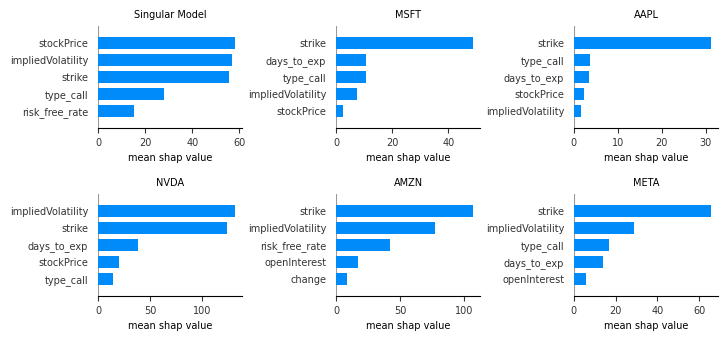

**Figure 4**. Top 5 feature predictors based on mean SHAP value

In [31]:
display(fig1)
display(Markdown("**Figure 4**. Top 5 feature predictors based on mean SHAP value"))

### Feature contribution to option price for a certain instance per model

Shown below is the effect of feature values on the option price for a given instance for the singular and per ticker models.

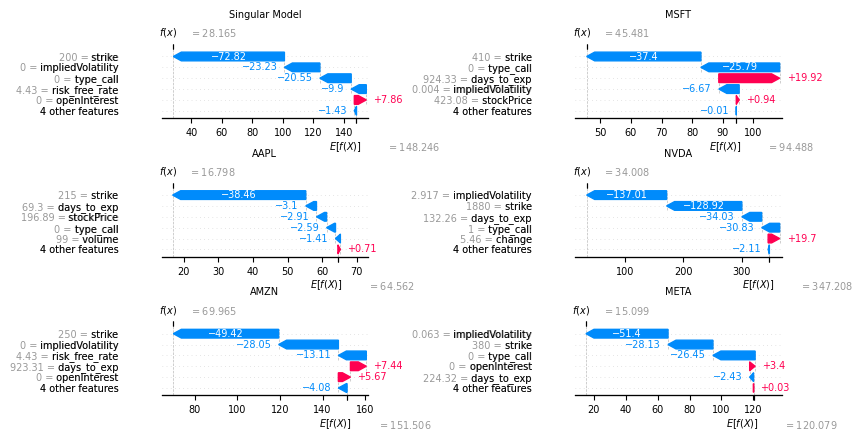

**Figure 5**. Feature contribution on option price SHAP waterfall plot

In [32]:
display(fig2)
display(Markdown("**Figure 5**. Feature contribution on option price SHAP waterfall plot"))

## Business Value

ML is already used to predict option prices in financial institutions, such as the Millennium Fund. This institution utilizes machine learning and hidden Markov chains to consistently outperform the baseline market and deliver the best returns to its client base. However, due to the financial nature of the method used to price options, the specific predictive techniques are not commonly shared with the public.

These models provide a fundamental understanding of how options might be priced using machine learning, using openly-available data from Yahoo! Finance and popular machine learning models. A potential business application for this approach could be seen in institutional market makers, who provide liquidity to markets. By leveraging machine learning to price options, these market makers can optimize the value of the liquidity they provide.

## Conclusion

To conclude, the main uses of the models we have introduced in this project is:
- **<u>Efficient Pricing</u>** -  ML models are able to process more data versus traditional methods in pricing options. This leads to more accurate and fair options price.
- **<u>Enhanced decision-making</u>** - ML allows analyst gain deeper insight on which factors options pricing. Both buy and sell side  benefits from efficient price by making more informed and timely decisions.
- **<u>Opportunity for use and leverage in the Global Derivatives Market</u>** - By utilizing an efficient and accurate model for pricing, you can gain a competitive edge and capitalize on this immense market opportunity. The whole global derivatives market is priced at ~1 quadirillion dollars, a competitive edge and capturing a very small slice of that pie will be an immense opportunity for huge profits!

## References

<sup>1</sup> How Options Are Priced. Investopedia Team. May 2024. https://www.investopedia.com/articles/optioninvestor/07/options_beat_market.asp

<sup>2</sup> Black-Scholes Model: What It Is, How It Works, and Options Formula. Adam Hayes. June 2024. https://www.investopedia.com/terms/b/blackscholes.asp

<sup>3</sup> The Trillion Dollar Equation. [Video] Available at: https://www.youtube.com/watch?v=A5w-dEgIU1M

<sup>4</sup> 4 Advantages of Options. Ron Ianieri. December 2023. https://www.investopedia.com/articles/optioninvestor/06/options4advantages.asp

<sup>5</sup> S&P 500 ETF Components. Accessed June 2024. https://www.slickcharts.com/sp500